# Generative Adversarial Networks

In this jupyter notebook we implement generative adversarial networks which allows to generate data from the training data distribution.
[Generative adversarial networks](https://en.wikipedia.org/wiki/Generative_adversarial_network) implement a form of unsupervised learning.
The main idea is that there is a generator network $G$, generating data $\hat{x}$ out of some random input $z$ from the latent space. Additionally,  there is a discriminator network $D$ which outputs the probability whether $\hat{x}$ is generated or actually is a true training example $x \sim p(X)$.
Both, the generator $G$ and the discriminator $D$ play a zero-sum game (ideally) resulting in a Nash equilibrium where neither the discriminator can predict with more than 50\% accuracy whether $\hat{x}$ is fake or real and also the generator cannot trick the discriminator into classifying more than 50% of the generated data as real.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from einops.layers.torch import Rearrange
import matplotlib
import matplotlib.pyplot as plt

## Loading the Training Data

Here we will use the (balanced) extended MNIST dataset containing the numbers 0 to 9. Below you see a random choice of training examples.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                # transform from[0,1] to [-1,1]
                                transforms.Normalize((0.5,), (0.5,)),
                                ])
mb_size = 100
training_data = torchvision.datasets.MNIST(
    "../variational-autoencoder/data/MNIST", "balanced", download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size=mb_size,
                                          shuffle=True,
                                          num_workers=2)

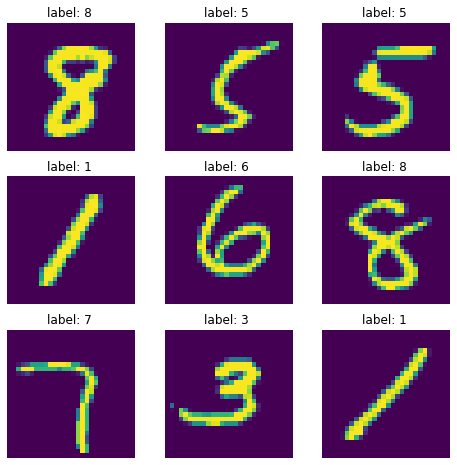

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("label: {} ".format(label))
    plt.axis("off")
    plt.imshow(img.squeeze(0))
plt.show()

## Definition of the Discriminator and Generator Networks

For GANs the convergence is often problematic and dependent on the network layouts.

The simplest architecture for the discriminator and generator network which I came across is taken from https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb
where both networks are just feedforward neural networks.

Another example for a well converging GAN architecture with more efficient convolution layers is the deep convolutional GAN (DCGAN) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html .

### Definition of the Discriminator Network

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size**2, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method,
    def discriminate(self, images):
        x = torch.flatten(images, 1) #flatten all dimensions except batch
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc4(x))
        return x

### Definition of the Generator Network

In [5]:
class Generator(nn.Module):
    def __init__(self, input_size, dimensionality_latent_distribution):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(dimensionality_latent_distribution, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, input_size**2)
        self.input_size = input_size
    
    # forward method
    def generate(self, input_noise):
        x = F.leaky_relu(self.fc1(input_noise), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        x = torch.reshape(x, (x.shape[0], self.input_size, self.input_size))
        return x.unsqueeze(1)

Next we obtain the instances of our discriminator network and the generator network and the optimizers for the discriminator and the generator.

In [6]:
dimensionality_latent_distribution = 90
myDiscriminator = Discriminator(input_size=28)
myGenerator = Generator(
    input_size=28, dimensionality_latent_distribution=dimensionality_latent_distribution)

lr = 0.0002
beta1 = 0.5
optimizer_discriminator = optim.Adam(
    myDiscriminator.parameters(), lr=lr)
optimizer_generator = optim.Adam(myGenerator.parameters(), lr=lr)

Next, we define the training procedure consisting of two steps:
1. Training the discriminator which tries to estimate the probability $D_\theta = q_\theta$ that some data from the training set is real or generated. The training set is periodically updated to contain real data as well as newly generated fake data. We maximize the log-likelihood $\log(\mathcal{L}(\theta))$ (i.e. minimize the cross entropy $H(p,q)=-E_p(\log(q_\theta))=-\sum_i p(X=i) \log(q_\theta(X=i)$, see [relation to cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_log-likelihood) ) with respect to the parameters $\theta$ of the discriminator. When the data in the training set $\{x_i\}$ is distributed according to $x_i \sim p(X=x_i)$ being real or fake, then we have $H\approx - \frac{1}{N} \sum_i \log(q_\theta(x_i))$ which we minimize with respect to the discriminator parameters $\theta$.
2. Training the generator has the goal to trick the generator into classifying the generated data as real. Therefore, we need to maximize the probability which is returned by the discriminator: $D(G_\gamma(z_i))$ with respect to the parameters  $\gamma$ of the generator (or since the logarithm does not change the location of maxima) we can also maximize $E_p[\log(D(G_\gamma(z_i)))]$ with respect to $\gamma$ (or minimize $-E_p[\log(D(G_\gamma(z_i)))]$, which can be done via the binary_cross_entropy and setting the target value to 1).


In [7]:
valid = torch.ones(mb_size).unsqueeze(1)- 1e-1*torch.ones(mb_size).unsqueeze(1) #label smoothing for numerical stability, ideally it would be torch.ones(mb_size).unsqueeze(1)
invalid = 1e-1*torch.ones(mb_size).unsqueeze(1) #label smoothing for numerical stability, ideally it would be torch.zeros(mb_size).unsqueeze(1)

def train_discriminator(input_noises):
    optimizer_discriminator.zero_grad()
    # discriminate real images
    verdict_real_images = myDiscriminator.discriminate(real_images)
    loss_real_discriminator = F.binary_cross_entropy(
        verdict_real_images, target=valid, reduction="sum")/mb_size

    # generate fake images
    fake_images = myGenerator.generate(input_noises)
    verdict_fake_images = myDiscriminator.discriminate(fake_images.detach())
    # discriminate fake images
    loss_fake_discriminator = F.binary_cross_entropy(
        verdict_fake_images, target=invalid, reduction="sum")/mb_size

    # compute total loss and propagate it
    loss_discriminator = loss_fake_discriminator+loss_real_discriminator
    loss_discriminator.backward()
    optimizer_discriminator.step()
    return loss_discriminator.detach().numpy()


def train_generator(input_noises):
    optimizer_generator.zero_grad()
    
    fake_images = myGenerator.generate(input_noises)
    verdict_fake_images = myDiscriminator.discriminate(fake_images)

    loss_fake_generator = F.binary_cross_entropy(
        verdict_fake_images, target=valid, reduction="sum")/mb_size

    loss_fake_generator.backward()
    optimizer_generator.step()
    return loss_fake_generator.detach().numpy(), fake_images.detach()

In [8]:
print("numer of parameters myDiscriminator", sum(dict((p.data_ptr(), p.numel())
      for p in myDiscriminator.parameters()).values()))
print("numer of parameters myGenerator", sum(dict((p.data_ptr(), p.numel())
      for p in myGenerator.parameters()).values()))

numer of parameters myDiscriminator 1460225
numer of parameters myGenerator 1483792


Epoch 0, Loss generator 0.6787593364715576, loss discriminator 1.3634111881256104


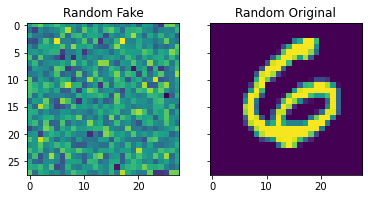

Epoch 0, Loss generator 1.2866352796554565, loss discriminator 1.012227177619934


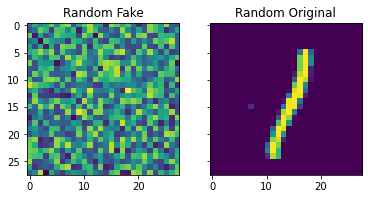

Epoch 0, Loss generator 2.6503820419311523, loss discriminator 0.7007459402084351


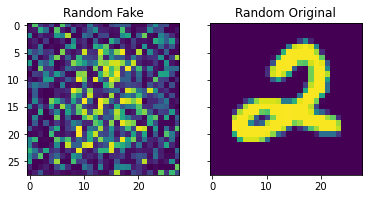

Epoch 0, Loss generator 2.253612756729126, loss discriminator 0.7085319757461548


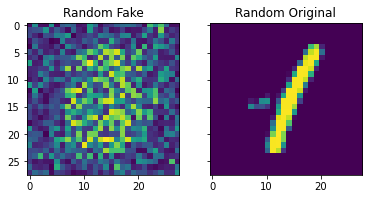

Epoch 0, Loss generator 1.5938583612442017, loss discriminator 1.2258059978485107


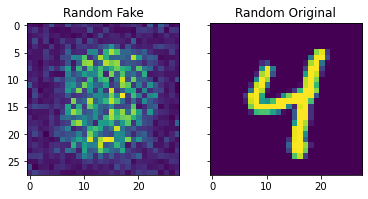

Epoch 0, Loss generator 2.060633897781372, loss discriminator 1.2335193157196045


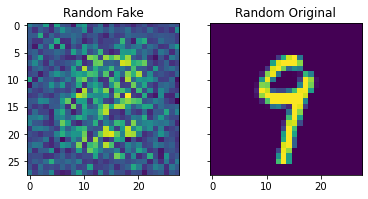

Epoch 0, Loss generator 3.117244005203247, loss discriminator 0.7115486860275269


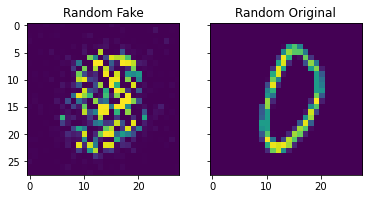

Epoch 0, Loss generator 2.412609338760376, loss discriminator 0.7749264240264893


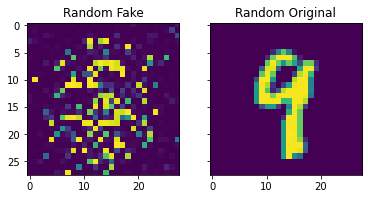

Epoch 0, Loss generator 2.164578914642334, loss discriminator 0.7170423269271851


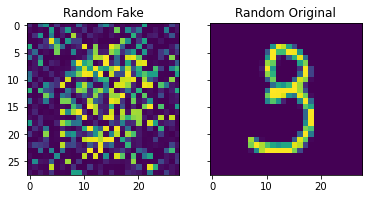

Epoch 0, Loss generator 2.2468528747558594, loss discriminator 1.0536940097808838


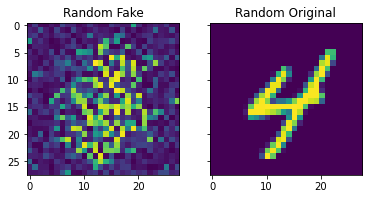

Epoch 0, Loss generator 2.2355151176452637, loss discriminator 0.7834880352020264


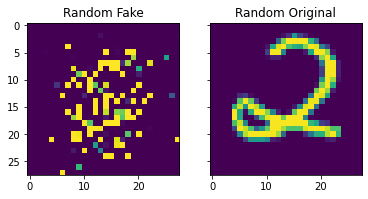

Epoch 0, Loss generator 2.111116647720337, loss discriminator 0.7577401995658875


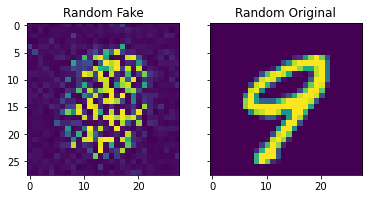

Epoch 1, Loss generator 2.950723171234131, loss discriminator 0.8393741846084595


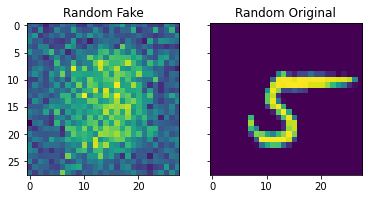

Epoch 1, Loss generator 2.506519317626953, loss discriminator 0.8219887018203735


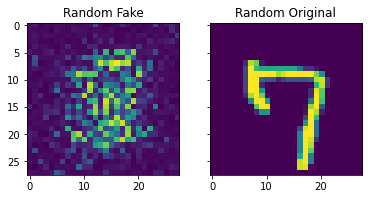

Epoch 1, Loss generator 1.4712207317352295, loss discriminator 1.1323175430297852


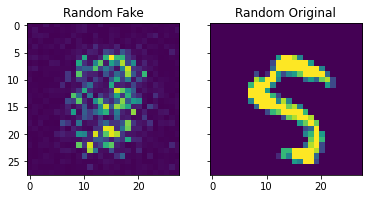

Epoch 1, Loss generator 2.0161190032958984, loss discriminator 0.8790363669395447


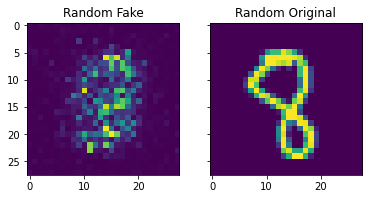

Epoch 1, Loss generator 1.4324418306350708, loss discriminator 0.9676156640052795


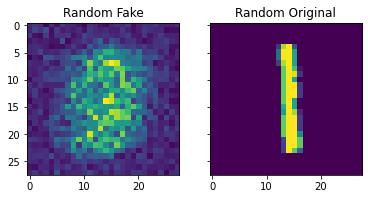

Epoch 1, Loss generator 1.7242659330368042, loss discriminator 0.9418648481369019


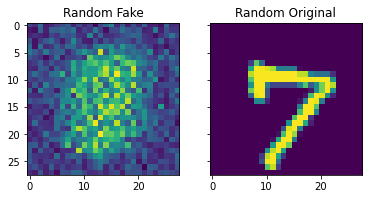

Epoch 1, Loss generator 1.6265339851379395, loss discriminator 1.1934847831726074


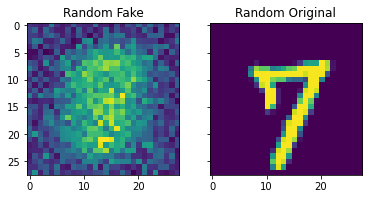

Epoch 1, Loss generator 1.426863193511963, loss discriminator 0.8577365875244141


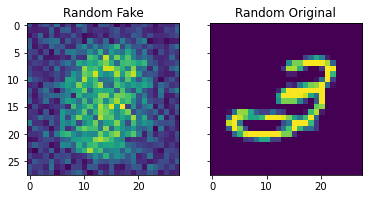

Epoch 1, Loss generator 2.2198739051818848, loss discriminator 0.9505661725997925


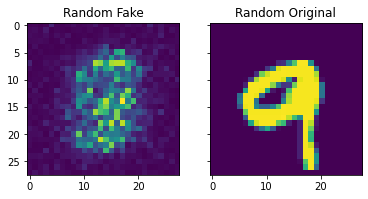

Epoch 1, Loss generator 1.9944908618927002, loss discriminator 0.7872133851051331


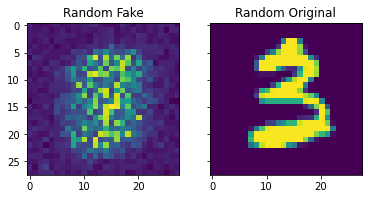

Epoch 1, Loss generator 1.8248742818832397, loss discriminator 0.8770731091499329


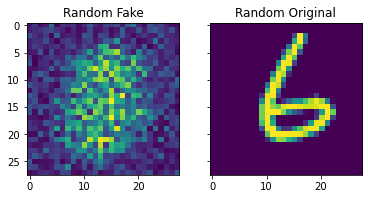

Epoch 1, Loss generator 1.148116946220398, loss discriminator 1.2766627073287964


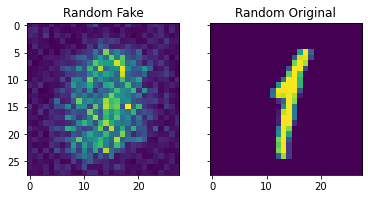

Epoch 2, Loss generator 2.4353339672088623, loss discriminator 1.0408191680908203


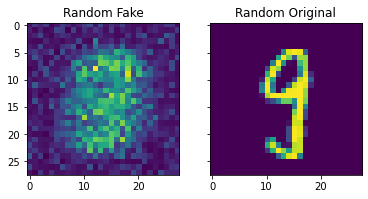

Epoch 2, Loss generator 2.397979497909546, loss discriminator 0.9288815259933472


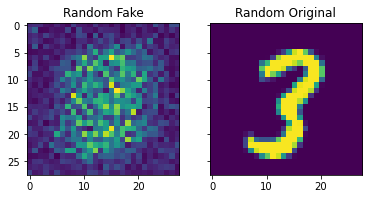

Epoch 2, Loss generator 0.7701941728591919, loss discriminator 1.2641652822494507


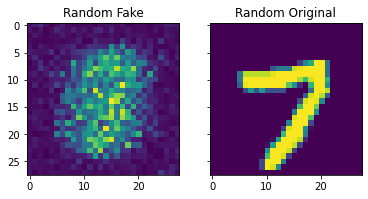

Epoch 2, Loss generator 1.5970948934555054, loss discriminator 0.8238868713378906


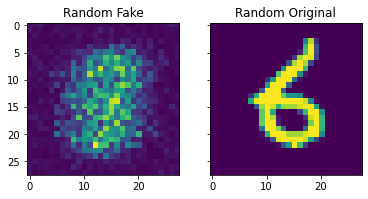

Epoch 2, Loss generator 1.3035496473312378, loss discriminator 0.9457544088363647


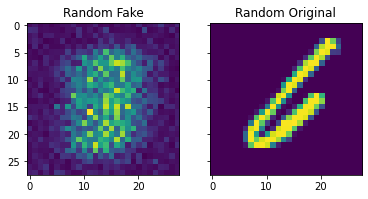

Epoch 2, Loss generator 1.3421565294265747, loss discriminator 1.1955394744873047


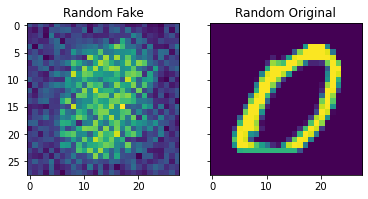

Epoch 2, Loss generator 1.0724040269851685, loss discriminator 1.3948144912719727


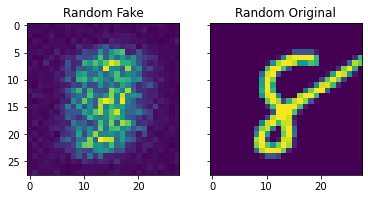

Epoch 2, Loss generator 1.2772531509399414, loss discriminator 0.9919837713241577


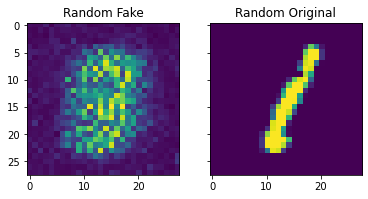

Epoch 2, Loss generator 2.390342950820923, loss discriminator 1.0750350952148438


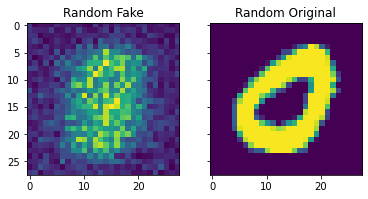

Epoch 2, Loss generator 1.167912244796753, loss discriminator 1.1537573337554932


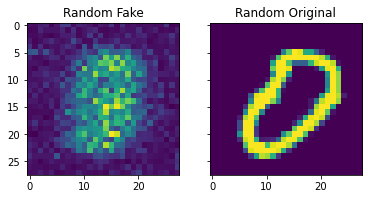

Epoch 2, Loss generator 1.3861935138702393, loss discriminator 1.042332410812378


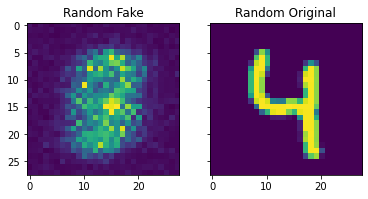

Epoch 2, Loss generator 2.241194486618042, loss discriminator 0.7821159362792969


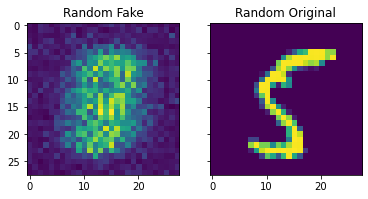

Epoch 3, Loss generator 1.0330383777618408, loss discriminator 1.1750770807266235


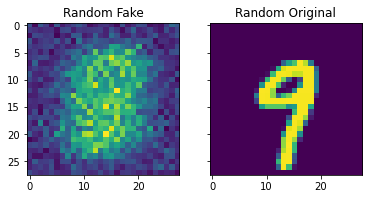

Epoch 3, Loss generator 2.211758852005005, loss discriminator 0.8989380598068237


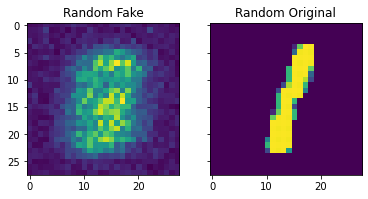

Epoch 3, Loss generator 1.6211860179901123, loss discriminator 0.8462933301925659


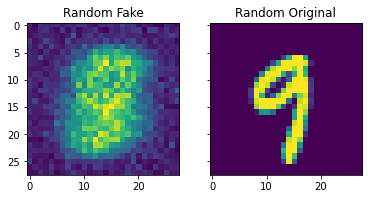

Epoch 3, Loss generator 1.7934660911560059, loss discriminator 0.8591923713684082


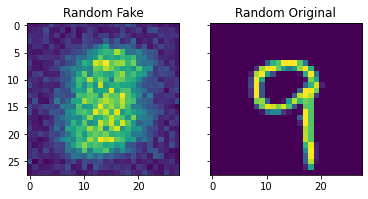

Epoch 3, Loss generator 1.612725853919983, loss discriminator 0.8880362510681152


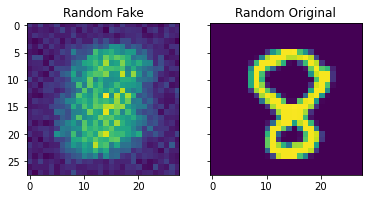

Epoch 3, Loss generator 1.2345715761184692, loss discriminator 1.041573166847229


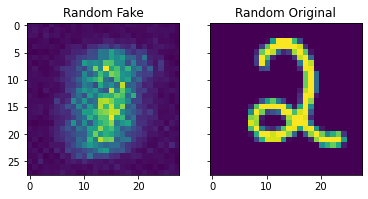

Epoch 3, Loss generator 1.3138835430145264, loss discriminator 0.9172306656837463


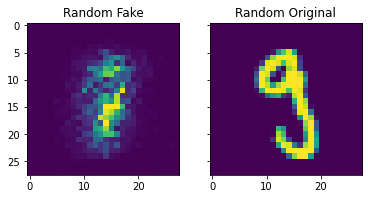

Epoch 3, Loss generator 1.4412509202957153, loss discriminator 1.055859088897705


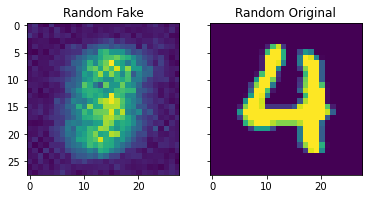

Epoch 3, Loss generator 1.7552709579467773, loss discriminator 0.8745937347412109


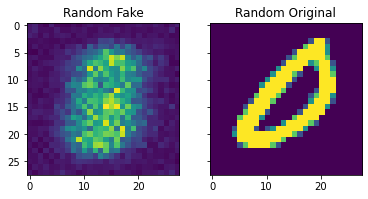

Epoch 3, Loss generator 1.7267885208129883, loss discriminator 0.7889499664306641


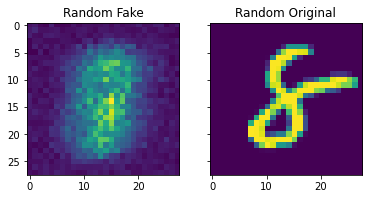

Epoch 3, Loss generator 2.0689196586608887, loss discriminator 0.790575385093689


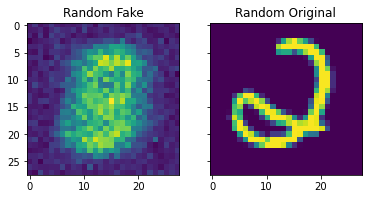

Epoch 3, Loss generator 1.9007142782211304, loss discriminator 0.7771890759468079


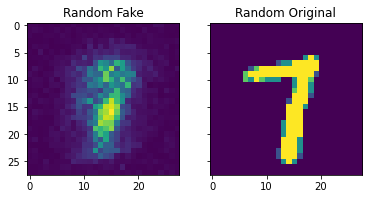

Epoch 4, Loss generator 1.8116281032562256, loss discriminator 0.9481062889099121


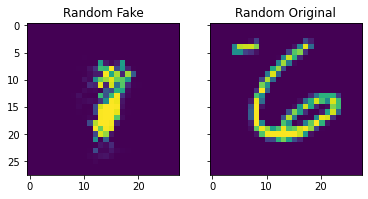

Epoch 4, Loss generator 1.9314407110214233, loss discriminator 0.8209975361824036


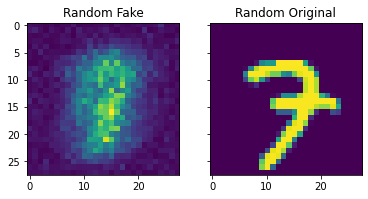

Epoch 4, Loss generator 1.4490077495574951, loss discriminator 0.939124584197998


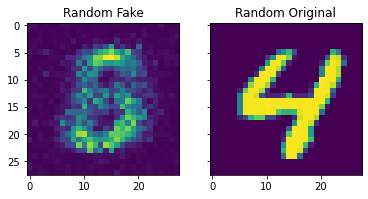

Epoch 4, Loss generator 1.9619195461273193, loss discriminator 0.8115156888961792


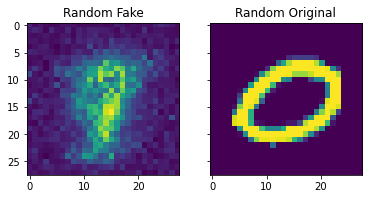

Epoch 4, Loss generator 1.9503926038742065, loss discriminator 0.7722776532173157


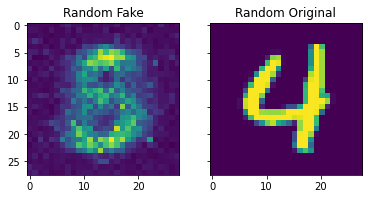

Epoch 4, Loss generator 2.1716432571411133, loss discriminator 0.7727305889129639


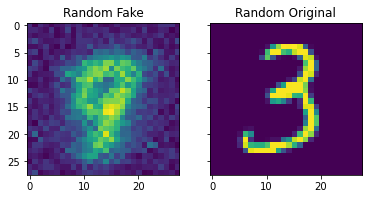

Epoch 4, Loss generator 2.0567786693573, loss discriminator 0.8153311610221863


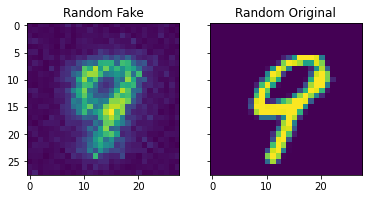

Epoch 4, Loss generator 1.6195709705352783, loss discriminator 0.9114629030227661


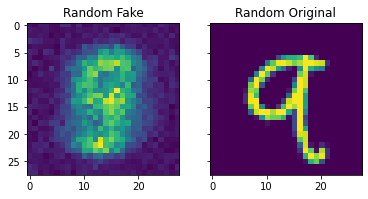

Epoch 4, Loss generator 1.8633695840835571, loss discriminator 0.9105021953582764


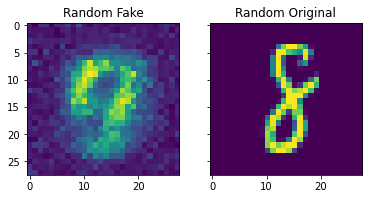

Epoch 4, Loss generator 1.5339665412902832, loss discriminator 0.9745794534683228


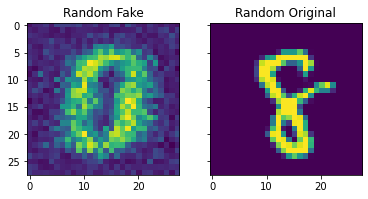

Epoch 4, Loss generator 1.6831661462783813, loss discriminator 0.8855361938476562


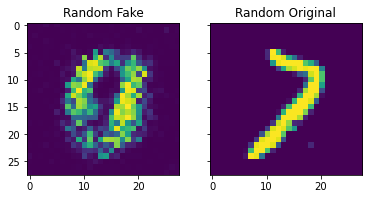

Epoch 4, Loss generator 1.8056048154830933, loss discriminator 0.7921249270439148


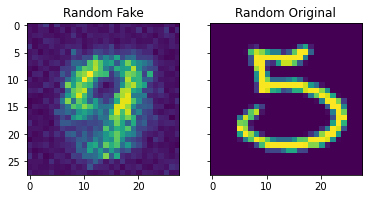

Epoch 5, Loss generator 2.0237789154052734, loss discriminator 0.8923648595809937


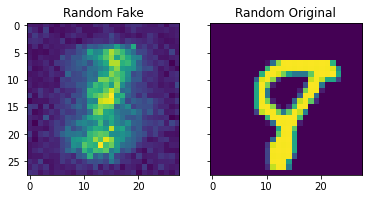

Epoch 5, Loss generator 1.912183403968811, loss discriminator 0.947736382484436


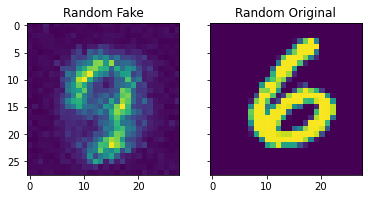

Epoch 5, Loss generator 2.040996551513672, loss discriminator 0.8049819469451904


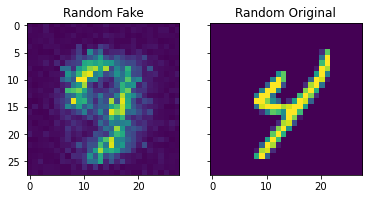

Epoch 5, Loss generator 1.7943131923675537, loss discriminator 0.93442302942276


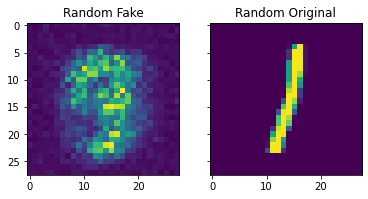

Epoch 5, Loss generator 1.7007992267608643, loss discriminator 0.9556674957275391


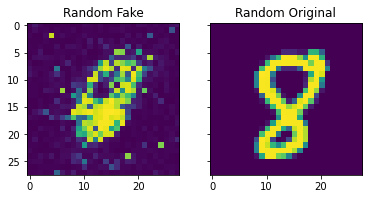

Epoch 5, Loss generator 1.7897708415985107, loss discriminator 0.8629927039146423


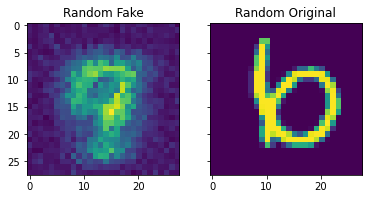

Epoch 5, Loss generator 1.942150592803955, loss discriminator 0.8301458954811096


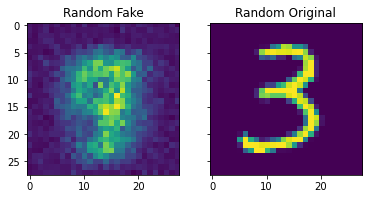

Epoch 5, Loss generator 1.644669771194458, loss discriminator 0.8525114059448242


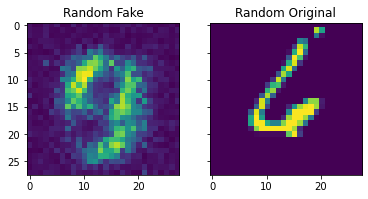

Epoch 5, Loss generator 1.9840383529663086, loss discriminator 0.8383892774581909


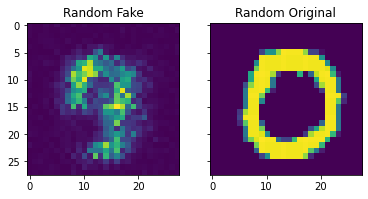

Epoch 5, Loss generator 1.940396785736084, loss discriminator 0.8986973762512207


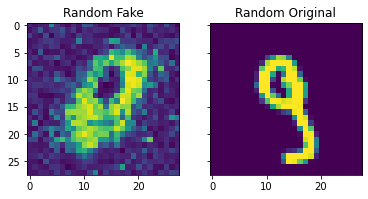

Epoch 5, Loss generator 1.7214893102645874, loss discriminator 0.7992538213729858


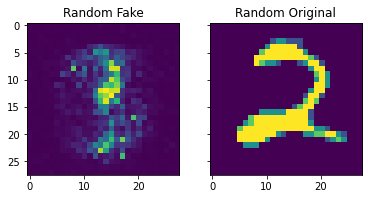

Epoch 5, Loss generator 1.980286717414856, loss discriminator 0.827472984790802


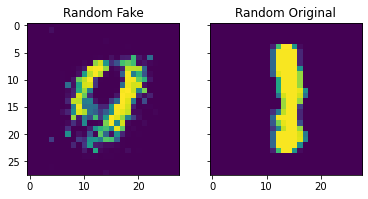

Epoch 6, Loss generator 1.5911768674850464, loss discriminator 0.8964958190917969


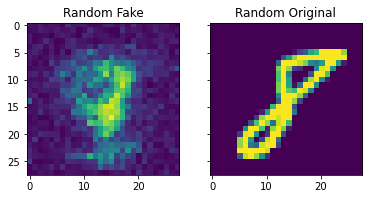

Epoch 6, Loss generator 1.4205060005187988, loss discriminator 0.9919824600219727


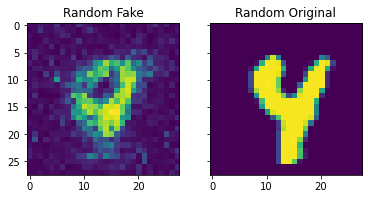

Epoch 6, Loss generator 1.814699649810791, loss discriminator 0.8088200092315674


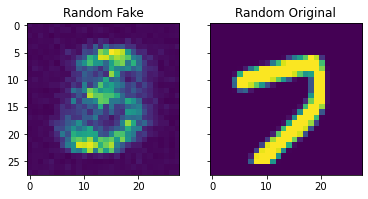

Epoch 6, Loss generator 2.258446216583252, loss discriminator 0.7610015273094177


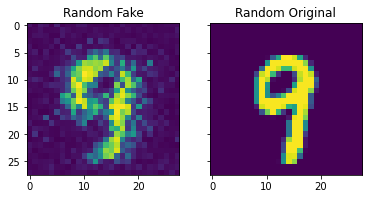

Epoch 6, Loss generator 1.8641135692596436, loss discriminator 0.8164858818054199


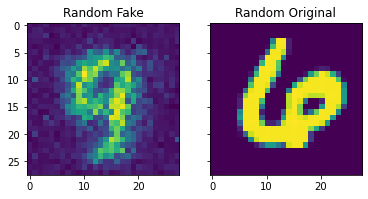

Epoch 6, Loss generator 2.014033317565918, loss discriminator 0.8266723155975342


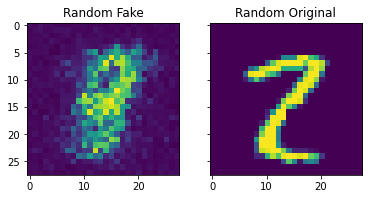

Epoch 6, Loss generator 1.9988511800765991, loss discriminator 0.7895009517669678


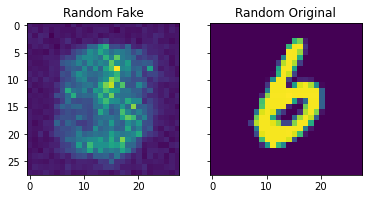

Epoch 6, Loss generator 1.7508490085601807, loss discriminator 0.8842083215713501


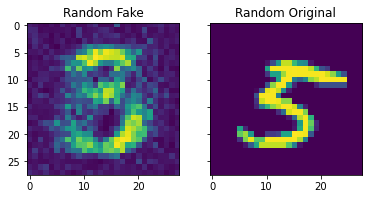

Epoch 6, Loss generator 1.9678477048873901, loss discriminator 0.9168881177902222


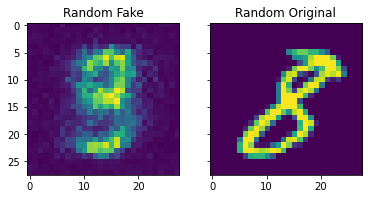

Epoch 6, Loss generator 1.6619470119476318, loss discriminator 0.8028186559677124


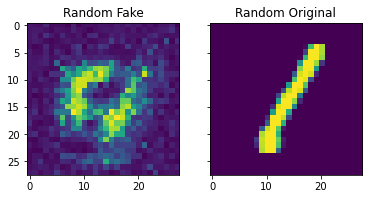

Epoch 6, Loss generator 1.6574841737747192, loss discriminator 0.8509408235549927


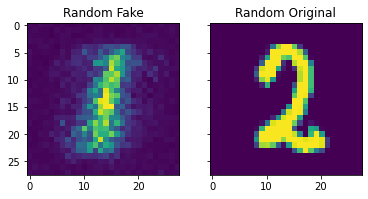

Epoch 6, Loss generator 1.5931254625320435, loss discriminator 1.0138334035873413


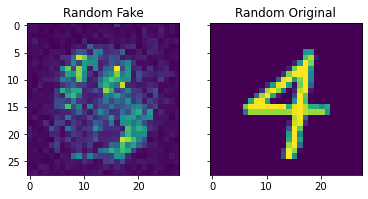

Epoch 7, Loss generator 1.3615739345550537, loss discriminator 1.063612461090088


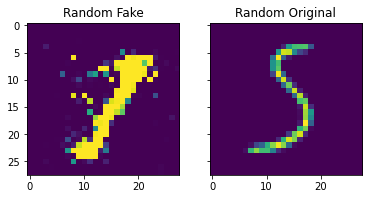

Epoch 7, Loss generator 1.7286590337753296, loss discriminator 1.026560664176941


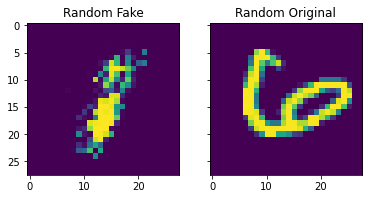

Epoch 7, Loss generator 1.848128318786621, loss discriminator 0.8161517381668091


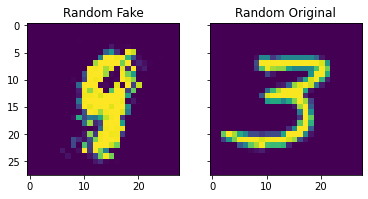

Epoch 7, Loss generator 1.5001837015151978, loss discriminator 1.052284836769104


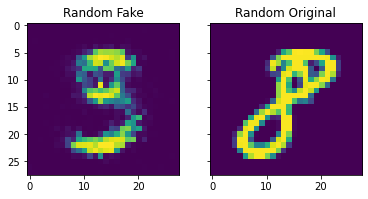

Epoch 7, Loss generator 1.5401843786239624, loss discriminator 0.9662739038467407


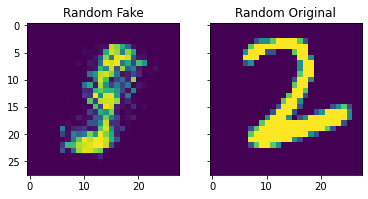

Epoch 7, Loss generator 1.515311598777771, loss discriminator 0.9046710133552551


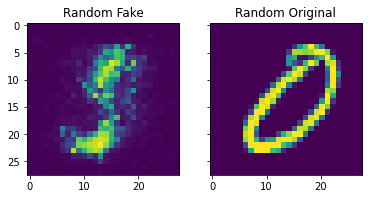

Epoch 7, Loss generator 1.2096136808395386, loss discriminator 1.0116742849349976


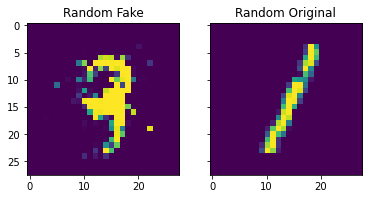

Epoch 7, Loss generator 1.4710520505905151, loss discriminator 0.9419689178466797


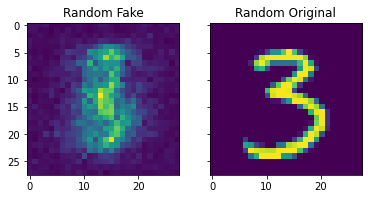

Epoch 7, Loss generator 2.070176124572754, loss discriminator 0.8694797158241272


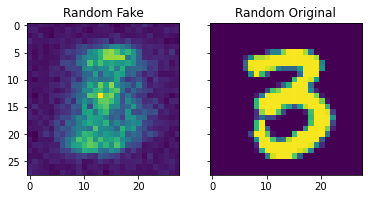

Epoch 7, Loss generator 1.2500951290130615, loss discriminator 0.8825030326843262


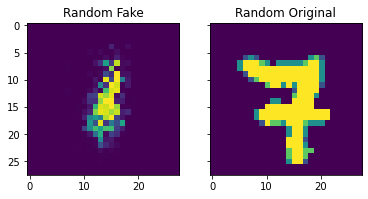

Epoch 7, Loss generator 1.420106053352356, loss discriminator 0.910263180732727


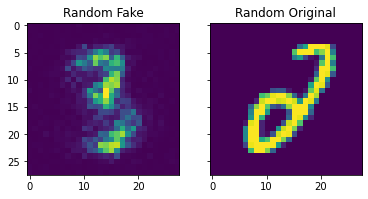

Epoch 7, Loss generator 1.4184467792510986, loss discriminator 1.0001394748687744


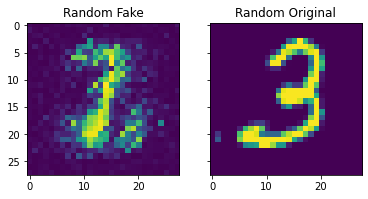

Epoch 8, Loss generator 1.8464767932891846, loss discriminator 0.8409930467605591


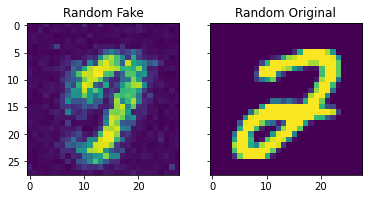

Epoch 8, Loss generator 1.746262550354004, loss discriminator 0.8772834539413452


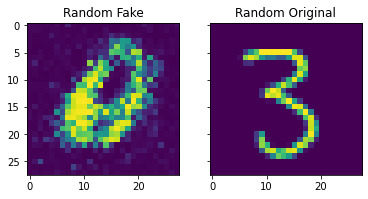

Epoch 8, Loss generator 1.7077854871749878, loss discriminator 0.953548789024353


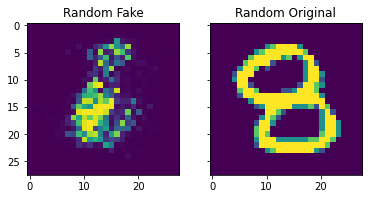

Epoch 8, Loss generator 1.7689611911773682, loss discriminator 0.8628685474395752


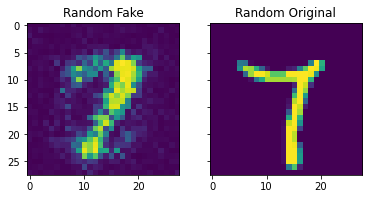

Epoch 8, Loss generator 1.5310592651367188, loss discriminator 1.0113188028335571


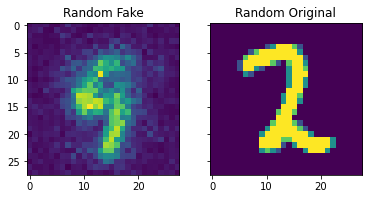

Epoch 8, Loss generator 1.5157841444015503, loss discriminator 1.0061233043670654


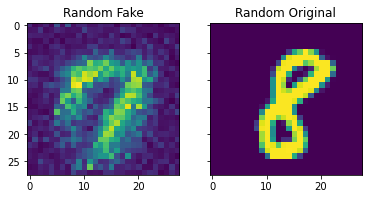

Epoch 8, Loss generator 1.7867300510406494, loss discriminator 0.8814234733581543


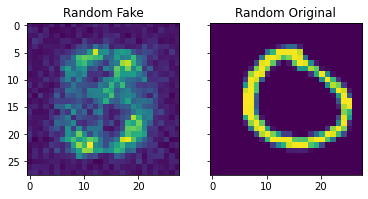

Epoch 8, Loss generator 1.2352075576782227, loss discriminator 1.0095698833465576


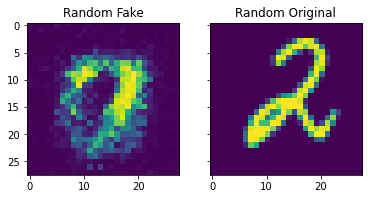

Epoch 8, Loss generator 1.329560399055481, loss discriminator 1.0170800685882568


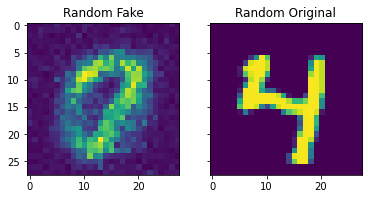

Epoch 8, Loss generator 1.397618293762207, loss discriminator 0.9675185084342957


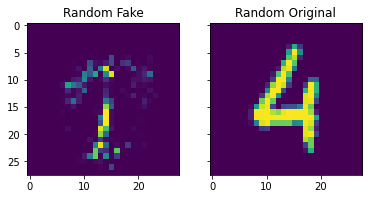

Epoch 8, Loss generator 2.0442159175872803, loss discriminator 0.9109259247779846


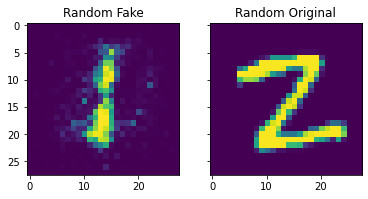

Epoch 8, Loss generator 1.4283233880996704, loss discriminator 1.0980913639068604


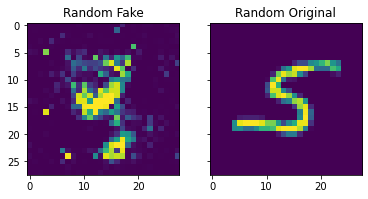

Epoch 9, Loss generator 1.594125509262085, loss discriminator 0.9934488534927368


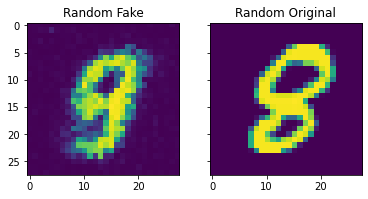

Epoch 9, Loss generator 1.51224684715271, loss discriminator 1.086489200592041


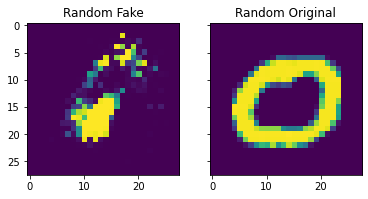

Epoch 9, Loss generator 1.5327473878860474, loss discriminator 0.9566799402236938


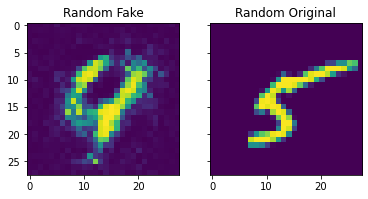

Epoch 9, Loss generator 1.311569333076477, loss discriminator 0.9968584775924683


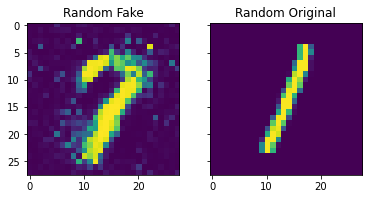

Epoch 9, Loss generator 1.4634428024291992, loss discriminator 1.071553111076355


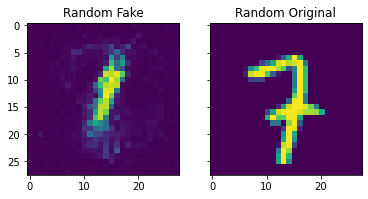

Epoch 9, Loss generator 1.1928677558898926, loss discriminator 1.192691683769226


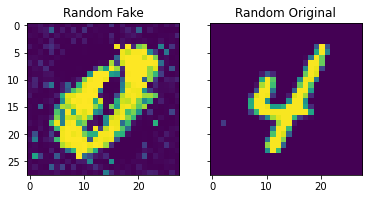

Epoch 9, Loss generator 1.258334755897522, loss discriminator 1.0930204391479492


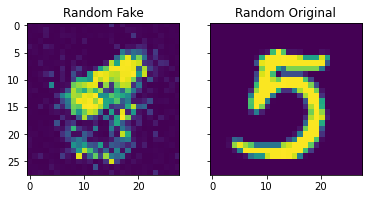

Epoch 9, Loss generator 0.9990189075469971, loss discriminator 1.054883360862732


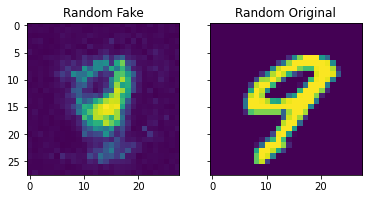

Epoch 9, Loss generator 1.4295105934143066, loss discriminator 1.0522547960281372


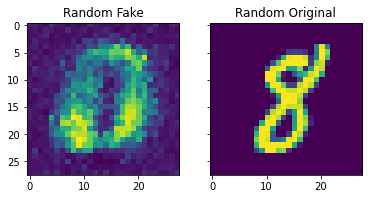

Epoch 9, Loss generator 1.4748425483703613, loss discriminator 0.9765772223472595


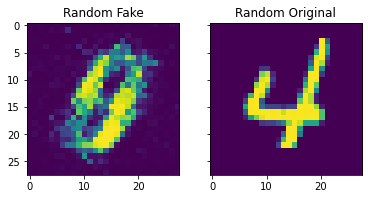

Epoch 9, Loss generator 1.1101993322372437, loss discriminator 1.0862374305725098


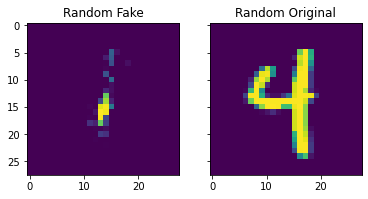

Epoch 9, Loss generator 1.1188182830810547, loss discriminator 1.0048294067382812


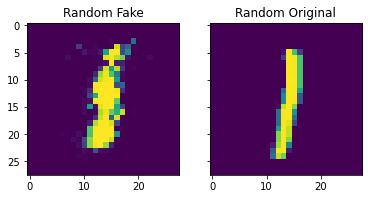

In [9]:
epochs = 10
for i in range(epochs):
    loss_discriminator = np.nan
    loss_fake_generator = np.nan
    for batch_idx, (real_images, real_labels) in enumerate(data_loader):
        real_labels = torch.nn.functional.one_hot(real_labels)

        input_noises = torch.randn(mb_size, dimensionality_latent_distribution)
        loss_discriminator = train_discriminator(input_noises)

        input_noises = torch.randn(mb_size, dimensionality_latent_distribution)
        loss_fake_generator, fake_images = train_generator(input_noises)

        if(batch_idx % 50 == 0):
            print("Epoch {}, Loss generator {}, loss discriminator {}".format(
                i, loss_fake_generator, loss_discriminator))
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            ax1.imshow(fake_images[0].squeeze(0).detach().numpy())
            ax1.set_title('Random Fake')
            ax2.set_title('Random Original')
            ax2.imshow(real_images[0].squeeze(0).detach().numpy())
            plt.show()

After 9 epochs the GAN converges to results which look similar to training digits in the MNIST dataset. We can sample from the generator via supplying some noise as input:

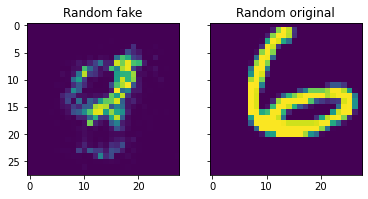

In [10]:
input_noises = torch.randn(mb_size, dimensionality_latent_distribution)
fake_images = myGenerator.generate(input_noises)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(fake_images[90].squeeze(0).detach().numpy())
ax1.set_title('Random fake')
ax2.set_title('Random original')
ax2.imshow(real_images[0].squeeze(0).detach().numpy())
plt.show()